[View in Colaboratory](https://colab.research.google.com/github/brynmwangy/predicting-bitcoin-prices-using-LSTM/blob/master/btc.ipynb)

In [ ]:
#install all the required dependancy libraries
!pip install tensorflow #for prediction
!pip install numpy  #for matrix multiplication
!pip install pandas #define the data structures
!pip install matplotlib #for visualization
!pip install scikit-learn #for normalizing our data(scaling)

#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline


In [1]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

In [1]:
#loading the dataset
from google.colab import files
uploaded = files.upload()

Saving btc.csv to btc.csv


In [2]:
#decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)
btc = pd.read_csv(io.StringIO(uploaded['btc.csv'].decode('utf-8'))).iloc[::-1]
btc.head()

NameError: name 'uploaded' is not defined

In [2]:
btc = pd.read_csv('btc.csv', encoding='utf-8').iloc[::-1]
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
1272,12/1/2014,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1271,12/2/2014,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1270,12/3/2014,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1269,12/4/2014,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1268,12/5/2014,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


In [3]:
#selecting only the column that we are going to use in the prediction process
data_to_use=btc['Close'].values
data_to_use

array([ 370.  ,  378.  ,  378.  , ..., 7584.15, 7459.11, 7520.  ])

In [6]:
print(len(data_to_use))

1273


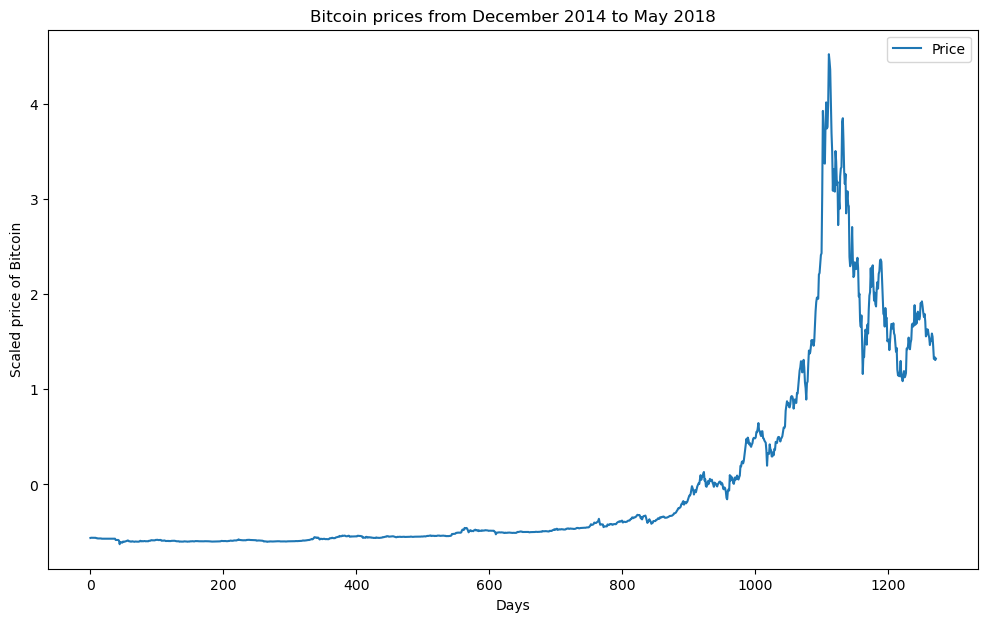

In [4]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
#plotting the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

In [7]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

window_size = 25

def window_data(data):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data)



X_train  = np.array(X[:900])
y_train = np.array(y[:900])

X_val = np.array(X[900:1000])
y_val = np.array(y[900:1000])

X_test = np.array(X[1000:])
y_test = np.array(y[1000:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_val.shape))
print("y_test size: {}".format(y_val.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (900, 25, 1)
y_train size: (900, 1)
X_test size: (100, 25, 1)
y_test size: (100, 1)
X_test size: (248, 25, 1)
y_test size: (248, 1)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def build_model(batch_size, hidden_layer, learning_rate):
    model = Sequential()
    model.add(LSTM(hidden_layer, batch_input_shape=(batch_size, window_size, 1)))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredError(), optimizer=optimizer)
    
    return model
"""
param_grid = {
    'batch_size': [32, 64, 128],
    'hidden_layer': [32, 64, 128, 256, 512],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [25]
}

"""
param_grid = {
    'batch_size': [32, 64],
    'hidden_layer': [32],
    'learning_rate': [0.01],
    'epochs': [5]
}


model = KerasRegressor(build_fn=build_model)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, return_train_score=True)
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))

# Imprimindo os melhores resultados
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")




C:\Users\juliana_oikawa\AppData\Local\Temp\2\ipykernel_5920\3222809032.py:34: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model)


Epoch 1/5
19/19 [==============================] - 4s 55ms/step - loss: 0.0201 - val_loss: 0.0453
Epoch 2/5
19/19 [==============================] - 0s 21ms/step - loss: 0.0025 - val_loss: 0.0228
Epoch 3/5
19/19 [==============================] - 0s 20ms/step - loss: 8.6711e-04 - val_loss: 0.0083
Epoch 4/5
19/19 [==============================] - 0s 21ms/step - loss: 2.5254e-04 - val_loss: 0.0047
Epoch 5/5
19/19 [==============================] - 0s 7ms/step - loss: 1.7076e-04
Epoch 1/5
19/19 [==============================] - 4s 53ms/step - loss: 0.0257 - val_loss: 0.0578
Epoch 2/5
19/19 [==============================] - 0s 21ms/step - loss: 0.0036 - val_loss: 0.0292
Epoch 3/5
19/19 [==============================] - 0s 21ms/step - loss: 0.0013 - val_loss: 0.0058
Epoch 4/5
19/19 [==============================] - 0s 22ms/step - loss: 3.3647e-04 - val_loss: 0.0073
Epoch 5/5
19/19 [==============================] - 0s 7ms/step - loss: 1.5618e-04
Epoch 1/5
19/19 [=======================

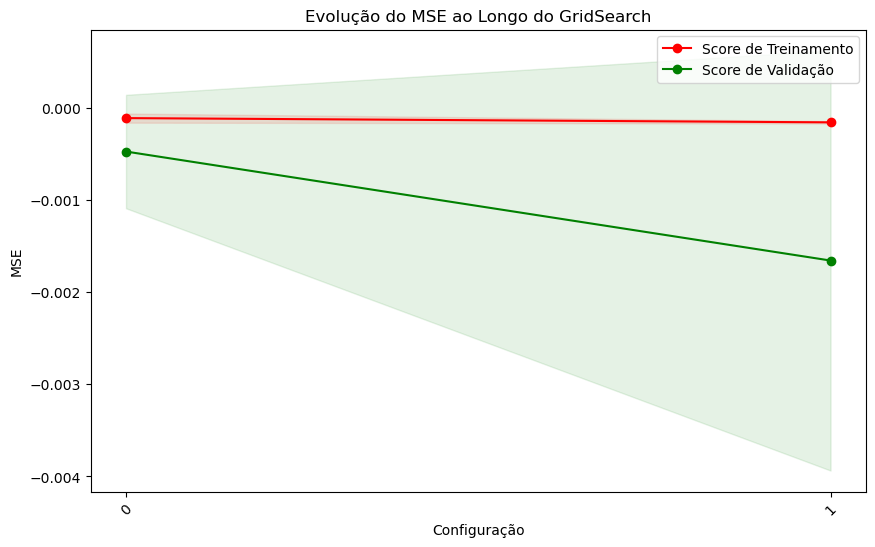

In [11]:
# Visualizar a evolução das métricas
import matplotlib.pyplot as plt

# Armazenar os scores de treinamento e validação para cada fold
train_scores_mean = grid_result.cv_results_["mean_train_score"]
train_scores_std = grid_result.cv_results_["std_train_score"]
test_scores_mean = grid_result.cv_results_["mean_test_score"]
test_scores_std = grid_result.cv_results_["std_test_score"]

# Plotar o MSE médio de treinamento e teste
plt.figure(figsize=(10, 6))
plt.title("Evolução do MSE ao Longo do GridSearch")
plt.xlabel("Configuração")
plt.ylabel("MSE")
plt.fill_between(range(len(train_scores_mean)), train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(range(len(test_scores_mean)), test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_scores_mean, 'o-', color="r", label="Score de Treinamento")
plt.plot(test_scores_mean, 'o-', color="g", label="Score de Validação")
plt.xticks(range(len(train_scores_mean)), rotation=45)
plt.legend(loc="best")
plt.show()

In [21]:
grid_result.best_params_

{'batch_size': 5,
 'epochs': 10,
 'hidden_layer': 128,
 'learning_rate': 0.01,
 'window_size': 7}

In [ ]:
#IMPRIMIR METRICAS

8/8 [==============================] - 1s 10ms/step
MSE: 0.1595184899302455
RMSE: 0.39939765889429735
COSINE: 0.9820882481951949


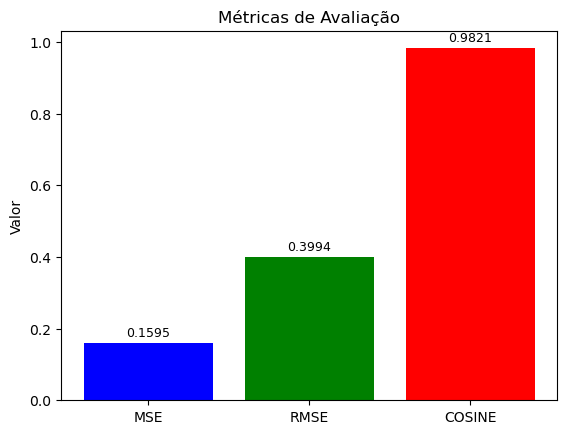

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cosine
import numpy as np

# Preveja os valores com o modelo treinado
y_pred = grid_result.predict(X_test).flatten()

# Certifique-se de que y_test é 1-D
y_test_1d = y_test.flatten()

# Calcule e imprima MSE
mse = mean_squared_error(y_test_1d, y_pred)
print(f"MSE: {mse}")

# Calcule e imprima RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Calcule e imprima COSINE
cosine_similarity = 1 - cosine(y_test_1d, y_pred)
print(f"COSINE: {cosine_similarity}")

import matplotlib.pyplot as plt

# ... [seu código acima]

# Visualização
metrics_names = ['MSE', 'RMSE', 'COSINE']
metrics_values = [mse, rmse, cosine_similarity]

plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red'])

# Adicionar títulos e labels
plt.title("Métricas de Avaliação")
plt.ylabel('Valor')
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, "%.4f" % v, ha='center', va='bottom', fontsize=9)

plt.show()


4/4 [==============================] - 1s 11ms/step


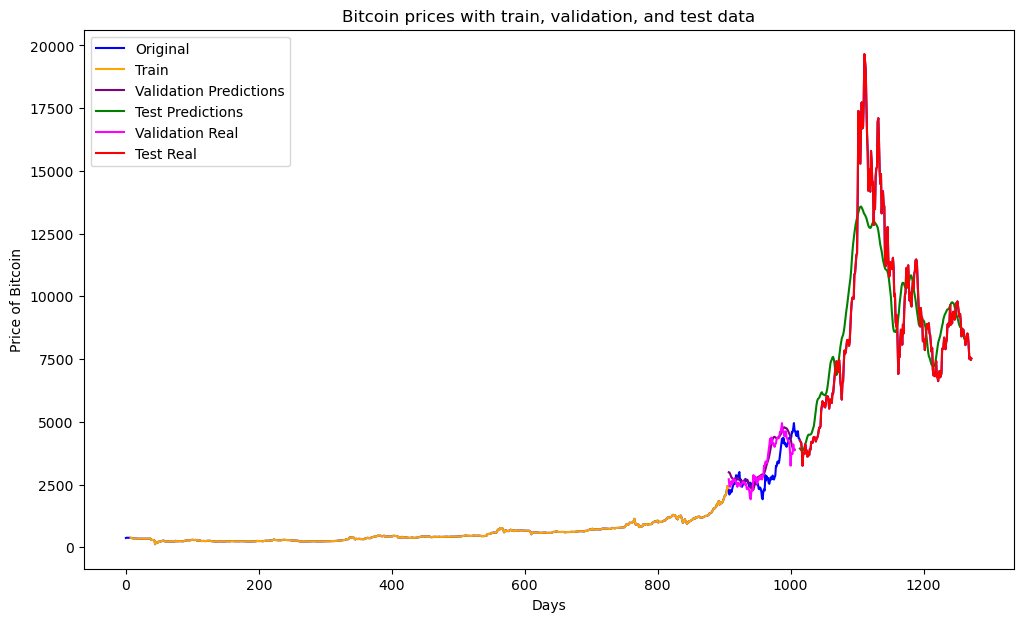

In [16]:
# ... [Your previous code]

# Using best model to make predictions on validation data
best_model = grid_result.best_estimator_.model
y_val_pred = best_model.predict(X_val)

# Criação do gráfico
plt.figure(figsize=(12,7))

# Plotagem dos dados originais
plt.plot(scaler.inverse_transform(scaled_data), color='blue', label='Original')

# Plotagem dos dados de treinamento
plt.plot(range(7, len(X_train) + 7), scaler.inverse_transform(scaled_data[7:len(X_train)+7]), color='orange', label='Train')

# Plotagem dos predictions no validation set
val_start_point = len(X_train) + 7
val_end_point = val_start_point + len(y_val_pred)
plt.plot(range(val_start_point, val_end_point), scaler.inverse_transform(y_val_pred.reshape(-1,1)), color='purple', label='Validation Predictions')

# Plotagem dos dados de teste
test_start_point = val_end_point + 7
test_end_point = test_start_point + len(y_pred)
plt.plot(range(test_start_point, test_end_point), scaler.inverse_transform(y_pred.reshape(-1,1)), color='green', label='Test Predictions')

# Plotagem dos real validation data
plt.plot(range(val_start_point, val_end_point), scaler.inverse_transform(y_val.reshape(-1,1)), color='magenta', label='Validation Real')

# Plotagem dos real test data
plt.plot(range(test_start_point, len(scaled_data)), scaler.inverse_transform(scaled_data[test_start_point:]), color='red', label='Test Real')

# Adição de legendas e mostrando o gráfico
plt.title('Bitcoin prices with train, validation, and test data')
plt.xlabel('Days')
plt.ylabel('Price of Bitcoin')
plt.legend()
plt.show()
